# Import required libraries


In [21]:
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import pylab
from scipy.interpolate import interp1d
from torch import Tensor
from tqdm import tqdm  # Progress bar
from IPython.display import set_matplotlib_formats
from matplotlib.colors import to_rgba
!pip install optuna
import optuna

torch.manual_seed(12)

%matplotlib inline
set_matplotlib_formats('svg')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.4 MB/s eta 0:00:00


<ipython-input-21-840c85e220dc>:19: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


# Define XOR Dataset Class


In [2]:
class XORDataset(data.Dataset):
    def __init__(self, size, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label


# Define MLP Neural Network Class


In [3]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2, 128)
        self.activation_1 = nn.ReLU()
        self.layer_2 = nn.Linear(128, 256)
        self.activation_2 = nn.ReLU()
        self.layer_3 = nn.Linear(256, 32)
        self.activation_3 = nn.ReLU()
        self.layer_4 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.activation_1(x)
        x = self.layer_2(x)
        x = self.activation_2(x)
        x = self.layer_3(x)
        x = self.activation_3(x)
        x = self.layer_4(x)
        return x


# Instantiate the MLP model, loss module and optimizer


In [4]:
model = MLP()
print("model summary with print model\n", model)

loss_module = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


model summary with print model
 MLP(
  (layer_1): Linear(in_features=2, out_features=128, bias=True)
  (activation_1): ReLU()
  (layer_2): Linear(in_features=128, out_features=256, bias=True)
  (activation_2): ReLU()
  (layer_3): Linear(in_features=256, out_features=32, bias=True)
  (activation_3): ReLU()
  (layer_4): Linear(in_features=32, out_features=1, bias=True)
)


# Setup TensorBoard and train the model


In [5]:
from torch.utils.tensorboard import SummaryWriter

log_dir = "logs"
writer = SummaryWriter(log_dir)

def train_model(model, optimizer, data_loader, loss_module, num_epochs=50):
    model.train()

    for epoch in tqdm(range(num_epochs)):
        for data_inputs,data_labels in data_loader:
            optimizer.zero_grad()

            outputs = model(data_inputs)

            data_labels_float = data_labels.type(torch.float32).unsqueeze(1)
            loss = loss_module(outputs, data_labels_float)

            loss.backward()
            optimizer.step()

        writer.add_scalar("loss", loss.item(), epoch)
        writer.flush()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

    print("Training complete.")

# Define the dataset, data_loader and train the model
xor_dataset = XORDataset(size=1000, std=0.1)
data_loader = data.DataLoader(xor_dataset, batch_size=32, shuffle=True)

train_model(model, optimizer, data_loader, loss_module, num_epochs=50)



 22%|██▏       | 11/50 [00:01<00:07,  5.13it/s]

Epoch [10/50], Loss: 0.0723


 42%|████▏     | 21/50 [00:04<00:07,  3.80it/s]

Epoch [20/50], Loss: 0.0048


 64%|██████▍   | 32/50 [00:06<00:01,  9.11it/s]

Epoch [30/50], Loss: 0.0056


 84%|████████▍ | 42/50 [00:07<00:00, 11.00it/s]

Epoch [40/50], Loss: 0.0041


100%|██████████| 50/50 [00:07<00:00,  6.37it/s]

Epoch [50/50], Loss: 0.0052
Training complete.


# Evaluate the trained model


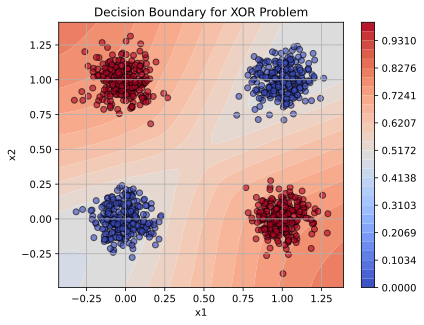

In [6]:
def plot_decision_boundary(model, data, label, title):
    model.eval()

    x = np.linspace(data[:, 0].min() - 0.1, data[:, 0].max() + 0.1, 200)
    y = np.linspace(data[:, 1].min() - 0.1, data[:, 1].max() + 0.1, 200)
    X, Y = np.meshgrid(x, y)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    Z = model(torch.tensor(xy, dtype=torch.float32)).detach().numpy().reshape(X.shape)
    Z = 1 / (1 + np.exp(-Z))

    fig, ax = plt.subplots()
    c = ax.contourf(X, Y, Z, cmap="coolwarm", levels=np.linspace(0, 1, 30))
    cb = plt.colorbar(c)

    scatter = ax.scatter(data[:, 0], data[:, 1], c=label, cmap="coolwarm", edgecolors="k", alpha=0.6)
    plt.xlim(data[:, 0].min() - 0.1, data[:, 0].max() + 0.1)
    plt.ylim(data[:, 1].min() - 0.1, data[:, 1].max() + 0.1)
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.grid(True)
    plt.show()

# Plot decision boundary for the XOR problem
data_numpy = xor_dataset.data.numpy()
label_numpy = xor_dataset.label.numpy()
plot_decision_boundary(model, data_numpy, label_numpy, "Decision Boundary for XOR Problem")


# Area of class 1 function


In [7]:
def area_of_class1(model):
    x1 = torch.arange(-0.5, 1.5, step=0.01, device='cpu')
    x2 = torch.arange(-0.5, 1.5, step=0.01, device='cpu')
    xx1, xx2 = torch.meshgrid(x1, x2) 
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)     
    x = preds[:,:,0]
    y = x
    n, m = y.shape
    z = Tensor([0 if value <= 0.5 else 1 for value in y.flatten()]).reshape((n, m, 1))
    preds = z
    oled = np.sum(preds.cpu().numpy())
    return oled


# Obtain default model weights


In [9]:
w_default = model.layer_4.weight
w_default2 = w_default.clone()
w_real_default = w_default.detach().clone().numpy()
print(w_real_default)
print(w_default[0])


[[ 0.13895741  0.29587895  0.26528937  0.0665952   0.17639267  0.3937765
   0.16542068 -0.07703232  0.06467964 -0.11498455 -0.00204619  0.3808598
  -0.13847278 -0.04893401  0.13085234 -0.27829936 -0.05762309 -0.04509126
   0.15109229 -0.08020449  0.0889011  -0.05905863 -0.11477828  0.04999132
   0.40897524  0.2927827  -0.11381276  0.32745364 -0.1785102   0.03450492
  -0.15616676 -0.12561117]]
tensor([ 0.1390,  0.2959,  0.2653,  0.0666,  0.1764,  0.3938,  0.1654, -0.0770,
         0.0647, -0.1150, -0.0020,  0.3809, -0.1385, -0.0489,  0.1309, -0.2783,
        -0.0576, -0.0451,  0.1511, -0.0802,  0.0889, -0.0591, -0.1148,  0.0500,
         0.4090,  0.2928, -0.1138,  0.3275, -0.1785,  0.0345, -0.1562, -0.1256],
       grad_fn=<SelectBackward0>)


# Neuron projection function


In [10]:
def neuron_projection(weights_of_final_layer):
    weights_copy = weights_of_final_layer
    non_negative_indexes = torch.where(weights_copy[0] != 0)[0]
    non_negative_indexes_list = non_negative_indexes.tolist()
    end_neuron_projected = np.array([50, 50])
    final_layer_project = np.linspace(0, 100, len(non_negative_indexes_list))
    return end_neuron_projected, final_layer_project, len(non_negative_indexes_list), non_negative_indexes


# Plot neurons function


In [11]:
def plot_neurons(end_neuron_proj, final_layer_proj, length):
    for i in range(length):
        plt.scatter(final_layer_proj[i], 0, edgecolor="#333")
    plt.scatter(end_neuron_proj[0], end_neuron_proj[1], edgecolor="#222")
    plt.title("Projected neurons")
    plt.legend()
    plt.show()


# Project and plot neurons


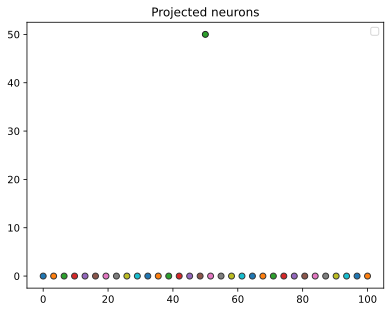

In [12]:
e, f, l, nni = neuron_projection(w_default)
plot_neurons(e, f, l)


# Interpolation function


In [13]:
def interpfun(points, values):
    f_cubic = interp1d(points, values, kind="cubic")
    return f_cubic


# Plot interpolation function


In [14]:
def plot_interp(f_cubic, points, values):
    pylab.plot(points, values, 'o', label='data points')
    pylab.plot(points, f_cubic(points), label='cubic')
    pylab.legend()
    pylab.show()


# Interpolate and plot data


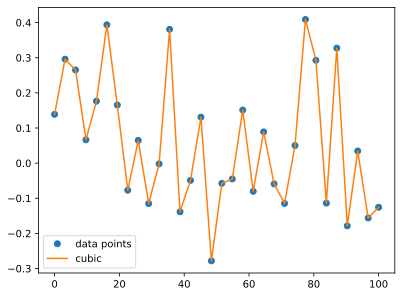

In [15]:
points = torch.linspace(0, 100, l)  
values = w_real_default[0][nni]
f = interpfun(points, values)
plot_interp(f, points, values)


# Final layer weight modifier function


In [16]:
def final_layer_weight_modifier(weight_gradients, modification, non_negative_indexes, f_cubic):
    points = torch.linspace(0, 100, len(non_negative_indexes))  
    points_2 = points
    weight_gradients2 = weight_gradients
    for i in range(len(points)):
        points_2[i] = (points[i] + modification) % 100
    weight_gradients2[0][non_negative_indexes] = torch.Tensor(f_cubic(points_2))
    return weight_gradients2


# Optuna optimization


[I 2023-05-07 17:36:46,830] A new study created in memory with name: no-name-2422148d-7d7a-48b6-b6ab-0f4d806115ec


sum1 is  13370.0


[I 2023-05-07 17:36:47,650] Trial 0 finished with value: 10696.0 and parameters: {'x': 14.255970228487136}. Best is trial 0 with value: 10696.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:36:48,125] Trial 1 finished with value: 10658.0 and parameters: {'x': 2.3904358766495215}. Best is trial 1 with value: 10658.0.


sum2 is  38.0
sum1 is  13370.0


[I 2023-05-07 17:36:48,616] Trial 2 finished with value: 10696.0 and parameters: {'x': 36.97133711099584}. Best is trial 1 with value: 10658.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:36:49,103] Trial 3 finished with value: 10696.0 and parameters: {'x': 3.898769895070575}. Best is trial 1 with value: 10658.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:36:49,864] Trial 4 finished with value: 10696.0 and parameters: {'x': 44.0522168980756}. Best is trial 1 with value: 10658.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:36:50,340] Trial 5 finished with value: 10696.0 and parameters: {'x': 39.07601475016719}. Best is trial 1 with value: 10658.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:36:50,830] Trial 6 finished with value: 10696.0 and parameters: {'x': 55.204239834736825}. Best is trial 1 with value: 10658.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:36:51,303] Trial 7 finished with value: 10696.0 and parameters: {'x': 95.30874393864426}. Best is trial 1 with value: 10658.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:36:52,053] Trial 8 finished with value: 10671.0 and parameters: {'x': 26.12807788835587}. Best is trial 1 with value: 10658.0.


sum2 is  25.0
sum1 is  13370.0


[I 2023-05-07 17:36:52,546] Trial 9 finished with value: 10696.0 and parameters: {'x': 43.042429291277365}. Best is trial 1 with value: 10658.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:36:53,029] Trial 10 finished with value: 10696.0 and parameters: {'x': 3.651376749915471}. Best is trial 1 with value: 10658.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:36:53,521] Trial 11 finished with value: 10696.0 and parameters: {'x': 19.917167922575164}. Best is trial 1 with value: 10658.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:36:54,282] Trial 12 finished with value: 10696.0 and parameters: {'x': 22.48587734529862}. Best is trial 1 with value: 10658.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:36:54,784] Trial 13 finished with value: 5110.0 and parameters: {'x': 0.9186792344612051}. Best is trial 13 with value: 5110.0.


sum2 is  15806.0
sum1 is  13370.0


[I 2023-05-07 17:36:55,275] Trial 14 finished with value: 10696.0 and parameters: {'x': 3.727278212925114}. Best is trial 13 with value: 5110.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:36:55,773] Trial 15 finished with value: 10696.0 and parameters: {'x': 12.33916890752763}. Best is trial 13 with value: 5110.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:36:56,263] Trial 16 finished with value: 1632.0 and parameters: {'x': 1.6747042961882284}. Best is trial 16 with value: 1632.0.


sum2 is  9064.0
sum1 is  13370.0


[I 2023-05-07 17:36:57,208] Trial 17 finished with value: 7098.0 and parameters: {'x': 27.840572533903973}. Best is trial 16 with value: 1632.0.


sum2 is  3598.0
sum1 is  13370.0


[I 2023-05-07 17:36:57,978] Trial 18 finished with value: 10696.0 and parameters: {'x': 13.417000377985296}. Best is trial 16 with value: 1632.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:36:58,749] Trial 19 finished with value: 10696.0 and parameters: {'x': 59.89310521086233}. Best is trial 16 with value: 1632.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:36:59,486] Trial 20 finished with value: 10543.0 and parameters: {'x': 30.1238482963182}. Best is trial 16 with value: 1632.0.


sum2 is  153.0
sum1 is  13370.0


[I 2023-05-07 17:37:00,344] Trial 21 finished with value: 10696.0 and parameters: {'x': 13.575254207619276}. Best is trial 16 with value: 1632.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:00,843] Trial 22 finished with value: 9951.0 and parameters: {'x': 29.898314164370372}. Best is trial 16 with value: 1632.0.


sum2 is  745.0
sum1 is  13370.0


[I 2023-05-07 17:37:01,324] Trial 23 finished with value: 10696.0 and parameters: {'x': 10.158533582904507}. Best is trial 16 with value: 1632.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:01,821] Trial 24 finished with value: 10696.0 and parameters: {'x': 18.81392998516547}. Best is trial 16 with value: 1632.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:02,301] Trial 25 finished with value: 10696.0 and parameters: {'x': 2.7144439023725724}. Best is trial 16 with value: 1632.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:03,059] Trial 26 finished with value: 10696.0 and parameters: {'x': 22.72746089414538}. Best is trial 16 with value: 1632.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:03,546] Trial 27 finished with value: 10390.0 and parameters: {'x': 6.967414670992975}. Best is trial 16 with value: 1632.0.


sum2 is  306.0
sum1 is  13370.0


[I 2023-05-07 17:37:04,038] Trial 28 finished with value: 2402.0 and parameters: {'x': 1.2914284586528078}. Best is trial 16 with value: 1632.0.


sum2 is  13098.0
sum1 is  13370.0


[I 2023-05-07 17:37:04,517] Trial 29 finished with value: 10695.0 and parameters: {'x': 9.733941470370842}. Best is trial 16 with value: 1632.0.


sum2 is  1.0
sum1 is  13370.0


[I 2023-05-07 17:37:05,275] Trial 30 finished with value: 3077.0 and parameters: {'x': 1.2096620673329996}. Best is trial 16 with value: 1632.0.


sum2 is  13773.0
sum1 is  13370.0


[I 2023-05-07 17:37:05,764] Trial 31 finished with value: 10696.0 and parameters: {'x': 2.49601348522948}. Best is trial 16 with value: 1632.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:06,253] Trial 32 finished with value: 2746.0 and parameters: {'x': 1.2505003194741517}. Best is trial 16 with value: 1632.0.


sum2 is  13442.0
sum1 is  13370.0


[I 2023-05-07 17:37:06,739] Trial 33 finished with value: 10696.0 and parameters: {'x': 16.36204603748852}. Best is trial 16 with value: 1632.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:07,508] Trial 34 finished with value: 9289.0 and parameters: {'x': 8.277651859874222}. Best is trial 16 with value: 1632.0.


sum2 is  1407.0
sum1 is  13370.0


[I 2023-05-07 17:37:08,006] Trial 35 finished with value: 8731.0 and parameters: {'x': 0.0046208797360307585}. Best is trial 16 with value: 1632.0.


sum2 is  19427.0
sum1 is  13370.0


[I 2023-05-07 17:37:08,480] Trial 36 finished with value: 9843.0 and parameters: {'x': 9.05492840468864}. Best is trial 16 with value: 1632.0.


sum2 is  853.0
sum1 is  13370.0


[I 2023-05-07 17:37:08,991] Trial 37 finished with value: 10696.0 and parameters: {'x': 16.653533860071402}. Best is trial 16 with value: 1632.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:09,780] Trial 38 finished with value: 9714.0 and parameters: {'x': 7.630885542768424}. Best is trial 16 with value: 1632.0.


sum2 is  982.0
sum1 is  13370.0


[I 2023-05-07 17:37:10,505] Trial 39 finished with value: 8476.0 and parameters: {'x': 0.11465508985546613}. Best is trial 16 with value: 1632.0.


sum2 is  19172.0
sum1 is  13370.0


[I 2023-05-07 17:37:11,245] Trial 40 finished with value: 10696.0 and parameters: {'x': 14.718713627936616}. Best is trial 16 with value: 1632.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:12,000] Trial 41 finished with value: 10696.0 and parameters: {'x': 5.800900406977918}. Best is trial 16 with value: 1632.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:12,739] Trial 42 finished with value: 8377.0 and parameters: {'x': 0.15105944799880544}. Best is trial 16 with value: 1632.0.


sum2 is  19073.0
sum1 is  13370.0


[I 2023-05-07 17:37:13,527] Trial 43 finished with value: 10696.0 and parameters: {'x': 6.169255723912509}. Best is trial 16 with value: 1632.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:14,011] Trial 44 finished with value: 10696.0 and parameters: {'x': 11.236852531634092}. Best is trial 16 with value: 1632.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:14,501] Trial 45 finished with value: 10696.0 and parameters: {'x': 5.431614203205274}. Best is trial 16 with value: 1632.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:14,987] Trial 46 finished with value: 7420.0 and parameters: {'x': 0.44720142869350005}. Best is trial 16 with value: 1632.0.


sum2 is  18116.0
sum1 is  13370.0


[I 2023-05-07 17:37:15,744] Trial 47 finished with value: 10696.0 and parameters: {'x': 18.903166242927476}. Best is trial 16 with value: 1632.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:16,234] Trial 48 finished with value: 10696.0 and parameters: {'x': 12.4585555611989}. Best is trial 16 with value: 1632.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:16,715] Trial 49 finished with value: 10696.0 and parameters: {'x': 4.967591801731191}. Best is trial 16 with value: 1632.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:17,205] Trial 50 finished with value: 10696.0 and parameters: {'x': 22.286206887785244}. Best is trial 16 with value: 1632.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:17,693] Trial 51 finished with value: 10696.0 and parameters: {'x': 4.585923571714378}. Best is trial 16 with value: 1632.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:18,450] Trial 52 finished with value: 10696.0 and parameters: {'x': 11.883968674569322}. Best is trial 16 with value: 1632.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:18,938] Trial 53 finished with value: 9280.0 and parameters: {'x': 8.387306453614896}. Best is trial 16 with value: 1632.0.


sum2 is  1416.0
sum1 is  13370.0


[I 2023-05-07 17:37:19,432] Trial 54 finished with value: 10696.0 and parameters: {'x': 14.472560442249321}. Best is trial 16 with value: 1632.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:19,929] Trial 55 finished with value: 10696.0 and parameters: {'x': 4.147124666929946}. Best is trial 16 with value: 1632.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:20,693] Trial 56 finished with value: 10626.0 and parameters: {'x': 26.211401549624966}. Best is trial 16 with value: 1632.0.


sum2 is  70.0
sum1 is  13370.0


[I 2023-05-07 17:37:21,175] Trial 57 finished with value: 7813.0 and parameters: {'x': 0.33695816359156106}. Best is trial 16 with value: 1632.0.


sum2 is  18509.0
sum1 is  13370.0


[I 2023-05-07 17:37:21,672] Trial 58 finished with value: 10696.0 and parameters: {'x': 9.94546489407577}. Best is trial 16 with value: 1632.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:22,156] Trial 59 finished with value: 10696.0 and parameters: {'x': 16.342675180759862}. Best is trial 16 with value: 1632.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:22,974] Trial 60 finished with value: 10696.0 and parameters: {'x': 2.812088417355223}. Best is trial 16 with value: 1632.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:23,731] Trial 61 finished with value: 10696.0 and parameters: {'x': 2.4740091186073596}. Best is trial 16 with value: 1632.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:24,486] Trial 62 finished with value: 8351.0 and parameters: {'x': 0.16074552778188433}. Best is trial 16 with value: 1632.0.


sum2 is  19047.0
sum1 is  13370.0


[I 2023-05-07 17:37:25,222] Trial 63 finished with value: 10354.0 and parameters: {'x': 7.002115117669397}. Best is trial 16 with value: 1632.0.


sum2 is  342.0
sum1 is  13370.0


[I 2023-05-07 17:37:26,187] Trial 64 finished with value: 10615.0 and parameters: {'x': 9.578879401547326}. Best is trial 16 with value: 1632.0.


sum2 is  81.0
sum1 is  13370.0


[I 2023-05-07 17:37:26,679] Trial 65 finished with value: 10696.0 and parameters: {'x': 4.013895347342403}. Best is trial 16 with value: 1632.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:27,161] Trial 66 finished with value: 10696.0 and parameters: {'x': 13.089370962589285}. Best is trial 16 with value: 1632.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:27,660] Trial 67 finished with value: 10696.0 and parameters: {'x': 5.505018802388948}. Best is trial 16 with value: 1632.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:28,146] Trial 68 finished with value: 10696.0 and parameters: {'x': 10.785624240725207}. Best is trial 16 with value: 1632.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:28,911] Trial 69 finished with value: 10696.0 and parameters: {'x': 35.12154091591588}. Best is trial 16 with value: 1632.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:29,398] Trial 70 finished with value: 9679.0 and parameters: {'x': 7.6762086681781225}. Best is trial 16 with value: 1632.0.


sum2 is  1017.0
sum1 is  13370.0


[I 2023-05-07 17:37:29,897] Trial 71 finished with value: 7760.0 and parameters: {'x': 0.35346501371313455}. Best is trial 16 with value: 1632.0.


sum2 is  18456.0
sum1 is  13370.0


[I 2023-05-07 17:37:30,379] Trial 72 finished with value: 765.0 and parameters: {'x': 1.6036191192726956}. Best is trial 72 with value: 765.0.


sum2 is  9931.0
sum1 is  13370.0


[I 2023-05-07 17:37:31,156] Trial 73 finished with value: 3652.0 and parameters: {'x': 1.8229791846557988}. Best is trial 72 with value: 765.0.


sum2 is  7044.0
sum1 is  13370.0


[I 2023-05-07 17:37:31,648] Trial 74 finished with value: 10696.0 and parameters: {'x': 3.7447453378759166}. Best is trial 72 with value: 765.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:32,141] Trial 75 finished with value: 9462.0 and parameters: {'x': 8.753643100422458}. Best is trial 72 with value: 765.0.


sum2 is  1234.0
sum1 is  13370.0


[I 2023-05-07 17:37:32,640] Trial 76 finished with value: 10696.0 and parameters: {'x': 2.982911400436869}. Best is trial 72 with value: 765.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:33,133] Trial 77 finished with value: 10658.0 and parameters: {'x': 6.67860987874346}. Best is trial 72 with value: 765.0.


sum2 is  38.0
sum1 is  13370.0


[I 2023-05-07 17:37:33,903] Trial 78 finished with value: 10696.0 and parameters: {'x': 15.274113198567017}. Best is trial 72 with value: 765.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:34,383] Trial 79 finished with value: 10696.0 and parameters: {'x': 11.697359466546867}. Best is trial 72 with value: 765.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:35,147] Trial 80 finished with value: 10696.0 and parameters: {'x': 17.84217318826757}. Best is trial 72 with value: 765.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:35,787] Trial 81 finished with value: 8902.0 and parameters: {'x': 2.163460086802047}. Best is trial 72 with value: 765.0.


sum2 is  1794.0
sum1 is  13370.0


[I 2023-05-07 17:37:38,087] Trial 82 finished with value: 7184.0 and parameters: {'x': 2.0514030783449604}. Best is trial 72 with value: 765.0.


sum2 is  3512.0
sum1 is  13370.0


[I 2023-05-07 17:37:38,831] Trial 83 finished with value: 10636.0 and parameters: {'x': 6.714454137796838}. Best is trial 72 with value: 765.0.


sum2 is  60.0
sum1 is  13370.0


[I 2023-05-07 17:37:39,496] Trial 84 finished with value: 10696.0 and parameters: {'x': 3.5793231021052394}. Best is trial 72 with value: 765.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:39,994] Trial 85 finished with value: 10696.0 and parameters: {'x': 6.309735646747498}. Best is trial 72 with value: 765.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:40,749] Trial 86 finished with value: 3603.0 and parameters: {'x': 1.8194519171265842}. Best is trial 72 with value: 765.0.


sum2 is  7093.0
sum1 is  13370.0


[I 2023-05-07 17:37:41,240] Trial 87 finished with value: 10696.0 and parameters: {'x': 13.702412533380029}. Best is trial 72 with value: 765.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:41,728] Trial 88 finished with value: 10696.0 and parameters: {'x': 9.884091275210249}. Best is trial 72 with value: 765.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:42,227] Trial 89 finished with value: 10696.0 and parameters: {'x': 5.572646125206697}. Best is trial 72 with value: 765.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:43,002] Trial 90 finished with value: 9830.0 and parameters: {'x': 9.046952584346016}. Best is trial 72 with value: 765.0.


sum2 is  866.0
sum1 is  13370.0


[I 2023-05-07 17:37:43,487] Trial 91 finished with value: 10628.0 and parameters: {'x': 2.378574692342833}. Best is trial 72 with value: 765.0.


sum2 is  68.0
sum1 is  13370.0


[I 2023-05-07 17:37:43,986] Trial 92 finished with value: 928.0 and parameters: {'x': 1.6172525229526584}. Best is trial 72 with value: 765.0.


sum2 is  9768.0
sum1 is  13370.0


[I 2023-05-07 17:37:44,470] Trial 93 finished with value: 8118.0 and parameters: {'x': 0.24311932724071306}. Best is trial 72 with value: 765.0.


sum2 is  18814.0
sum1 is  13370.0


[I 2023-05-07 17:37:44,969] Trial 94 finished with value: 10215.0 and parameters: {'x': 2.290615500947023}. Best is trial 72 with value: 765.0.


sum2 is  481.0
sum1 is  13370.0


[I 2023-05-07 17:37:45,708] Trial 95 finished with value: 10696.0 and parameters: {'x': 5.40328243774125}. Best is trial 72 with value: 765.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:46,199] Trial 96 finished with value: 10696.0 and parameters: {'x': 11.614922732111019}. Best is trial 72 with value: 765.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:46,690] Trial 97 finished with value: 9402.0 and parameters: {'x': 8.041790650609983}. Best is trial 72 with value: 765.0.


sum2 is  1294.0
sum1 is  13370.0


[I 2023-05-07 17:37:47,184] Trial 98 finished with value: 10696.0 and parameters: {'x': 4.418850652349308}. Best is trial 72 with value: 765.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:47,948] Trial 99 finished with value: 7333.0 and parameters: {'x': 2.0607177832565693}. Best is trial 72 with value: 765.0.


sum2 is  3363.0
sum1 is  13370.0


[I 2023-05-07 17:37:48,435] Trial 100 finished with value: 9939.0 and parameters: {'x': 7.391262980115184}. Best is trial 72 with value: 765.0.


sum2 is  757.0
sum1 is  13370.0


[I 2023-05-07 17:37:48,934] Trial 101 finished with value: 10354.0 and parameters: {'x': 2.31445027546392}. Best is trial 72 with value: 765.0.


sum2 is  342.0
sum1 is  13370.0


[I 2023-05-07 17:37:49,457] Trial 102 finished with value: 10696.0 and parameters: {'x': 4.449738851013672}. Best is trial 72 with value: 765.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:50,217] Trial 103 finished with value: 3419.0 and parameters: {'x': 1.1647258738967474}. Best is trial 72 with value: 765.0.


sum2 is  14115.0
sum1 is  13370.0


[I 2023-05-07 17:37:51,322] Trial 104 finished with value: 1428.0 and parameters: {'x': 1.3983293750671233}. Best is trial 72 with value: 765.0.


sum2 is  12124.0
sum1 is  13370.0


[I 2023-05-07 17:37:52,086] Trial 105 finished with value: 7197.0 and parameters: {'x': 0.5029363408542316}. Best is trial 72 with value: 765.0.


sum2 is  17893.0
sum1 is  13370.0


[I 2023-05-07 17:37:52,693] Trial 106 finished with value: 10696.0 and parameters: {'x': 4.849780957675364}. Best is trial 72 with value: 765.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:53,192] Trial 107 finished with value: 9789.0 and parameters: {'x': 7.546407636725328}. Best is trial 72 with value: 765.0.


sum2 is  907.0
sum1 is  13370.0


[I 2023-05-07 17:37:53,960] Trial 108 finished with value: 10696.0 and parameters: {'x': 10.810678367956431}. Best is trial 72 with value: 765.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:54,454] Trial 109 finished with value: 7846.0 and parameters: {'x': 0.32901319274951324}. Best is trial 72 with value: 765.0.


sum2 is  18542.0
sum1 is  13370.0


[I 2023-05-07 17:37:54,954] Trial 110 finished with value: 10696.0 and parameters: {'x': 3.943634184524269}. Best is trial 72 with value: 765.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:55,449] Trial 111 finished with value: 10696.0 and parameters: {'x': 5.4249173141383515}. Best is trial 72 with value: 765.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:37:56,217] Trial 112 finished with value: 419.0 and parameters: {'x': 1.4980690327943138}. Best is trial 112 with value: 419.0.


sum2 is  11115.0
sum1 is  13370.0


[I 2023-05-07 17:37:56,714] Trial 113 finished with value: 444.0 and parameters: {'x': 1.5764058524062206}. Best is trial 112 with value: 419.0.


sum2 is  10252.0
sum1 is  13370.0


[I 2023-05-07 17:37:57,656] Trial 114 finished with value: 9892.0 and parameters: {'x': 2.24676045888864}. Best is trial 112 with value: 419.0.


sum2 is  804.0
sum1 is  13370.0


[I 2023-05-07 17:37:58,526] Trial 115 finished with value: 2481.0 and parameters: {'x': 1.7390902389971583}. Best is trial 112 with value: 419.0.


sum2 is  8215.0
sum1 is  13370.0


[I 2023-05-07 17:37:59,792] Trial 116 finished with value: 10696.0 and parameters: {'x': 3.7302400777492397}. Best is trial 112 with value: 419.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:00,283] Trial 117 finished with value: 9597.0 and parameters: {'x': 7.783925438801346}. Best is trial 112 with value: 419.0.


sum2 is  1099.0
sum1 is  13370.0


[I 2023-05-07 17:38:00,784] Trial 118 finished with value: 246.0 and parameters: {'x': 1.514003806516361}. Best is trial 118 with value: 246.0.


sum2 is  10942.0
sum1 is  13370.0


[I 2023-05-07 17:38:01,276] Trial 119 finished with value: 10619.0 and parameters: {'x': 9.582428405699694}. Best is trial 118 with value: 246.0.


sum2 is  77.0
sum1 is  13370.0


[I 2023-05-07 17:38:01,775] Trial 120 finished with value: 10696.0 and parameters: {'x': 5.402335626819318}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:02,589] Trial 121 finished with value: 2251.0 and parameters: {'x': 1.3082355380642794}. Best is trial 118 with value: 246.0.


sum2 is  12947.0
sum1 is  13370.0


[I 2023-05-07 17:38:03,327] Trial 122 finished with value: 8047.0 and parameters: {'x': 0.2636965498294379}. Best is trial 118 with value: 246.0.


sum2 is  18743.0
sum1 is  13370.0


[I 2023-05-07 17:38:04,092] Trial 123 finished with value: 10696.0 and parameters: {'x': 2.977852246684856}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:04,861] Trial 124 finished with value: 8352.0 and parameters: {'x': 0.16024964900820682}. Best is trial 118 with value: 246.0.


sum2 is  19048.0
sum1 is  13370.0


[I 2023-05-07 17:38:05,826] Trial 125 finished with value: 10156.0 and parameters: {'x': 7.18476330270391}. Best is trial 118 with value: 246.0.


sum2 is  540.0
sum1 is  13370.0


[I 2023-05-07 17:38:06,316] Trial 126 finished with value: 10696.0 and parameters: {'x': 4.267039339756765}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:06,818] Trial 127 finished with value: 6982.0 and parameters: {'x': 2.03890622602158}. Best is trial 118 with value: 246.0.


sum2 is  3714.0
sum1 is  13370.0


[I 2023-05-07 17:38:07,308] Trial 128 finished with value: 10696.0 and parameters: {'x': 6.017757358327749}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:07,815] Trial 129 finished with value: 10696.0 and parameters: {'x': 12.61888243207142}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:08,573] Trial 130 finished with value: 8710.0 and parameters: {'x': 0.013735624561505455}. Best is trial 118 with value: 246.0.


sum2 is  19406.0
sum1 is  13370.0


[I 2023-05-07 17:38:09,074] Trial 131 finished with value: 6256.0 and parameters: {'x': 1.993342806495451}. Best is trial 118 with value: 246.0.


sum2 is  4440.0
sum1 is  13370.0


[I 2023-05-07 17:38:09,580] Trial 132 finished with value: 10696.0 and parameters: {'x': 3.8160734664513747}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:10,087] Trial 133 finished with value: 4002.0 and parameters: {'x': 1.846485484785851}. Best is trial 118 with value: 246.0.


sum2 is  6694.0
sum1 is  13370.0


[I 2023-05-07 17:38:10,857] Trial 134 finished with value: 10696.0 and parameters: {'x': 5.935056359452392}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:11,345] Trial 135 finished with value: 9743.0 and parameters: {'x': 8.987010394374764}. Best is trial 118 with value: 246.0.


sum2 is  953.0
sum1 is  13370.0


[I 2023-05-07 17:38:11,849] Trial 136 finished with value: 10696.0 and parameters: {'x': 3.56798777137161}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:12,341] Trial 137 finished with value: 8500.0 and parameters: {'x': 0.10259063650447642}. Best is trial 118 with value: 246.0.


sum2 is  19196.0
sum1 is  13370.0


[I 2023-05-07 17:38:13,112] Trial 138 finished with value: 10696.0 and parameters: {'x': 6.270962533496011}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:13,604] Trial 139 finished with value: 9030.0 and parameters: {'x': 2.1730809748158606}. Best is trial 118 with value: 246.0.


sum2 is  1666.0
sum1 is  13370.0


[I 2023-05-07 17:38:14,096] Trial 140 finished with value: 10696.0 and parameters: {'x': 10.205573484747466}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:14,580] Trial 141 finished with value: 3502.0 and parameters: {'x': 1.812266372285948}. Best is trial 118 with value: 246.0.


sum2 is  7194.0
sum1 is  13370.0


[I 2023-05-07 17:38:15,358] Trial 142 finished with value: 10696.0 and parameters: {'x': 3.916884442976113}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:16,023] Trial 143 finished with value: 8733.0 and parameters: {'x': 0.0030299633569996764}. Best is trial 118 with value: 246.0.


sum2 is  19429.0
sum1 is  13370.0


[I 2023-05-07 17:38:16,795] Trial 144 finished with value: 8377.0 and parameters: {'x': 2.1275158712906546}. Best is trial 118 with value: 246.0.


sum2 is  2319.0
sum1 is  13370.0


[I 2023-05-07 17:38:17,553] Trial 145 finished with value: 9658.0 and parameters: {'x': 7.702288530511811}. Best is trial 118 with value: 246.0.


sum2 is  1038.0
sum1 is  13370.0


[I 2023-05-07 17:38:18,310] Trial 146 finished with value: 10696.0 and parameters: {'x': 4.8492373711981545}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:19,169] Trial 147 finished with value: 10696.0 and parameters: {'x': 44.72380839798527}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:19,669] Trial 148 finished with value: 6492.0 and parameters: {'x': 2.0084572436206862}. Best is trial 118 with value: 246.0.


sum2 is  4204.0
sum1 is  13370.0


[I 2023-05-07 17:38:20,180] Trial 149 finished with value: 10696.0 and parameters: {'x': 4.0461220655276335}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:20,676] Trial 150 finished with value: 10696.0 and parameters: {'x': 6.420124260216846}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:21,464] Trial 151 finished with value: 4652.0 and parameters: {'x': 1.8902870989707086}. Best is trial 118 with value: 246.0.


sum2 is  6044.0
sum1 is  13370.0


[I 2023-05-07 17:38:21,974] Trial 152 finished with value: 10696.0 and parameters: {'x': 3.6213754511035394}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:22,478] Trial 153 finished with value: 8586.0 and parameters: {'x': 0.06769889195019729}. Best is trial 118 with value: 246.0.


sum2 is  19282.0
sum1 is  13370.0


[I 2023-05-07 17:38:22,989] Trial 154 finished with value: 10696.0 and parameters: {'x': 5.496599890534432}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:23,480] Trial 155 finished with value: 9284.0 and parameters: {'x': 8.4080928583837}. Best is trial 118 with value: 246.0.


sum2 is  1412.0
sum1 is  13370.0


[I 2023-05-07 17:38:24,260] Trial 156 finished with value: 4324.0 and parameters: {'x': 1.8682492235329229}. Best is trial 118 with value: 246.0.


sum2 is  6372.0
sum1 is  13370.0


[I 2023-05-07 17:38:24,780] Trial 157 finished with value: 10696.0 and parameters: {'x': 3.9699690808391725}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:25,299] Trial 158 finished with value: 8220.0 and parameters: {'x': 2.1174839959378735}. Best is trial 118 with value: 246.0.


sum2 is  2476.0
sum1 is  13370.0


[I 2023-05-07 17:38:25,809] Trial 159 finished with value: 10696.0 and parameters: {'x': 6.49928194340306}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:26,582] Trial 160 finished with value: 10696.0 and parameters: {'x': 32.374749573300925}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:27,097] Trial 161 finished with value: 3005.0 and parameters: {'x': 1.7773589910104557}. Best is trial 118 with value: 246.0.


sum2 is  7691.0
sum1 is  13370.0


[I 2023-05-07 17:38:27,593] Trial 162 finished with value: 10696.0 and parameters: {'x': 22.29170202392192}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:28,098] Trial 163 finished with value: 8685.0 and parameters: {'x': 0.02547905535026307}. Best is trial 118 with value: 246.0.


sum2 is  19381.0
sum1 is  13370.0


[I 2023-05-07 17:38:28,992] Trial 164 finished with value: 10696.0 and parameters: {'x': 3.798533712915293}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:29,760] Trial 165 finished with value: 1719.0 and parameters: {'x': 1.6810425046876603}. Best is trial 118 with value: 246.0.


sum2 is  8977.0
sum1 is  13370.0


[I 2023-05-07 17:38:30,528] Trial 166 finished with value: 10696.0 and parameters: {'x': 4.827979316457224}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:31,289] Trial 167 finished with value: 4845.0 and parameters: {'x': 1.9032745004167102}. Best is trial 118 with value: 246.0.


sum2 is  5851.0
sum1 is  13370.0


[I 2023-05-07 17:38:32,201] Trial 168 finished with value: 10696.0 and parameters: {'x': 24.298874022181117}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:32,704] Trial 169 finished with value: 9435.0 and parameters: {'x': 7.996503356326551}. Best is trial 118 with value: 246.0.


sum2 is  1261.0
sum1 is  13370.0


[I 2023-05-07 17:38:33,202] Trial 170 finished with value: 10696.0 and parameters: {'x': 3.2049526587041854}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:33,702] Trial 171 finished with value: 1809.0 and parameters: {'x': 1.6885078983737933}. Best is trial 118 with value: 246.0.


sum2 is  8887.0
sum1 is  13370.0


[I 2023-05-07 17:38:34,211] Trial 172 finished with value: 1304.0 and parameters: {'x': 1.4116449566077738}. Best is trial 118 with value: 246.0.


sum2 is  12000.0
sum1 is  13370.0


[I 2023-05-07 17:38:35,008] Trial 173 finished with value: 10696.0 and parameters: {'x': 5.486065307835754}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:35,506] Trial 174 finished with value: 8669.0 and parameters: {'x': 0.03199835842371601}. Best is trial 118 with value: 246.0.


sum2 is  19365.0
sum1 is  13370.0


[I 2023-05-07 17:38:36,008] Trial 175 finished with value: 10696.0 and parameters: {'x': 3.33245534608455}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:36,517] Trial 176 finished with value: 1034.0 and parameters: {'x': 1.6258678909785271}. Best is trial 118 with value: 246.0.


sum2 is  9662.0
sum1 is  13370.0


[I 2023-05-07 17:38:37,293] Trial 177 finished with value: 10696.0 and parameters: {'x': 58.23200704574537}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:37,803] Trial 178 finished with value: 10696.0 and parameters: {'x': 5.840685305884575}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:38,295] Trial 179 finished with value: 8594.0 and parameters: {'x': 0.0641791755395471}. Best is trial 118 with value: 246.0.


sum2 is  19290.0
sum1 is  13370.0


[I 2023-05-07 17:38:38,801] Trial 180 finished with value: 10696.0 and parameters: {'x': 3.392481159745019}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:39,296] Trial 181 finished with value: 460.0 and parameters: {'x': 1.577574941002351}. Best is trial 118 with value: 246.0.


sum2 is  10236.0
sum1 is  13370.0


[I 2023-05-07 17:38:40,083] Trial 182 finished with value: 10696.0 and parameters: {'x': 20.05167499949928}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:40,594] Trial 183 finished with value: 1996.0 and parameters: {'x': 1.7027969088017088}. Best is trial 118 with value: 246.0.


sum2 is  8700.0
sum1 is  13370.0


[I 2023-05-07 17:38:41,097] Trial 184 finished with value: 10696.0 and parameters: {'x': 4.567982146623829}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:41,611] Trial 185 finished with value: 1866.0 and parameters: {'x': 1.6925584493917665}. Best is trial 118 with value: 246.0.


sum2 is  8830.0
sum1 is  13370.0


[I 2023-05-07 17:38:42,631] Trial 186 finished with value: 10696.0 and parameters: {'x': 2.540341445398722}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:43,393] Trial 187 finished with value: 8692.0 and parameters: {'x': 0.022422211447802542}. Best is trial 118 with value: 246.0.


sum2 is  19388.0
sum1 is  13370.0


[I 2023-05-07 17:38:44,166] Trial 188 finished with value: 10696.0 and parameters: {'x': 64.75452728998599}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:44,912] Trial 189 finished with value: 10403.0 and parameters: {'x': 6.956295107934166}. Best is trial 118 with value: 246.0.


sum2 is  293.0
sum1 is  13370.0


[I 2023-05-07 17:38:45,691] Trial 190 finished with value: 9140.0 and parameters: {'x': 2.1808325572335363}. Best is trial 118 with value: 246.0.


sum2 is  1556.0
sum1 is  13370.0


[I 2023-05-07 17:38:46,184] Trial 191 finished with value: 10696.0 and parameters: {'x': 3.8391058162112905}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:46,694] Trial 192 finished with value: 3886.0 and parameters: {'x': 1.8385556471193767}. Best is trial 118 with value: 246.0.


sum2 is  6810.0
sum1 is  13370.0


[I 2023-05-07 17:38:47,191] Trial 193 finished with value: 10696.0 and parameters: {'x': 5.04609845837808}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:47,981] Trial 194 finished with value: 8685.0 and parameters: {'x': 0.02522805445518972}. Best is trial 118 with value: 246.0.


sum2 is  19381.0
sum1 is  13370.0


[I 2023-05-07 17:38:48,478] Trial 195 finished with value: 4817.0 and parameters: {'x': 1.9010681980944033}. Best is trial 118 with value: 246.0.


sum2 is  5879.0
sum1 is  13370.0


[I 2023-05-07 17:38:48,991] Trial 196 finished with value: 10696.0 and parameters: {'x': 3.4362715831385575}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:49,486] Trial 197 finished with value: 10696.0 and parameters: {'x': 5.795981338996343}. Best is trial 118 with value: 246.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:49,991] Trial 198 finished with value: 9321.0 and parameters: {'x': 8.535736963601167}. Best is trial 118 with value: 246.0.


sum2 is  1375.0
sum1 is  13370.0


[I 2023-05-07 17:38:50,754] Trial 199 finished with value: 148.0 and parameters: {'x': 1.523571957466395}. Best is trial 199 with value: 148.0.


sum2 is  10844.0
sum1 is  13370.0


[I 2023-05-07 17:38:51,264] Trial 200 finished with value: 7166.0 and parameters: {'x': 2.0504603904466814}. Best is trial 199 with value: 148.0.


sum2 is  3530.0
sum1 is  13370.0


[I 2023-05-07 17:38:51,765] Trial 201 finished with value: 8648.0 and parameters: {'x': 0.04068870551735526}. Best is trial 199 with value: 148.0.


sum2 is  19344.0
sum1 is  13370.0


[I 2023-05-07 17:38:52,269] Trial 202 finished with value: 10696.0 and parameters: {'x': 3.50359194553796}. Best is trial 199 with value: 148.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:53,054] Trial 203 finished with value: 1484.0 and parameters: {'x': 1.6625611056301581}. Best is trial 199 with value: 148.0.


sum2 is  9212.0
sum1 is  13370.0


[I 2023-05-07 17:38:53,546] Trial 204 finished with value: 10696.0 and parameters: {'x': 4.837899601811335}. Best is trial 199 with value: 148.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:54,053] Trial 205 finished with value: 4457.0 and parameters: {'x': 1.8770689636585542}. Best is trial 199 with value: 148.0.


sum2 is  6239.0
sum1 is  13370.0


[I 2023-05-07 17:38:54,545] Trial 206 finished with value: 10696.0 and parameters: {'x': 3.533982014158275}. Best is trial 199 with value: 148.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:55,140] Trial 207 finished with value: 10452.0 and parameters: {'x': 6.909797139546824}. Best is trial 199 with value: 148.0.


sum2 is  244.0
sum1 is  13370.0


[I 2023-05-07 17:38:56,213] Trial 208 finished with value: 1560.0 and parameters: {'x': 1.3847801155395263}. Best is trial 199 with value: 148.0.


sum2 is  12256.0
sum1 is  13370.0


[I 2023-05-07 17:38:56,967] Trial 209 finished with value: 10696.0 and parameters: {'x': 4.994685174361588}. Best is trial 199 with value: 148.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:38:57,720] Trial 210 finished with value: 160.0 and parameters: {'x': 1.5224331726259945}. Best is trial 199 with value: 148.0.


sum2 is  10856.0
sum1 is  13370.0


[I 2023-05-07 17:38:58,305] Trial 211 finished with value: 8658.0 and parameters: {'x': 0.03785587963672299}. Best is trial 199 with value: 148.0.


sum2 is  19354.0
sum1 is  13370.0


[I 2023-05-07 17:38:59,087] Trial 212 finished with value: 5129.0 and parameters: {'x': 1.9217310918929782}. Best is trial 199 with value: 148.0.


sum2 is  5567.0
sum1 is  13370.0


[I 2023-05-07 17:38:59,589] Trial 213 finished with value: 10696.0 and parameters: {'x': 3.7895142853489263}. Best is trial 199 with value: 148.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:00,102] Trial 214 finished with value: 2086.0 and parameters: {'x': 1.7096410878217378}. Best is trial 199 with value: 148.0.


sum2 is  8610.0
sum1 is  13370.0


[I 2023-05-07 17:39:00,598] Trial 215 finished with value: 1550.0 and parameters: {'x': 1.6674662395938458}. Best is trial 199 with value: 148.0.


sum2 is  9146.0
sum1 is  13370.0


[I 2023-05-07 17:39:01,383] Trial 216 finished with value: 10013.0 and parameters: {'x': 29.915613495354926}. Best is trial 199 with value: 148.0.


sum2 is  683.0
sum1 is  13370.0


[I 2023-05-07 17:39:01,885] Trial 217 finished with value: 10696.0 and parameters: {'x': 3.467236609246222}. Best is trial 199 with value: 148.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:02,383] Trial 218 finished with value: 6846.0 and parameters: {'x': 28.021997771090128}. Best is trial 199 with value: 148.0.


sum2 is  3850.0
sum1 is  13370.0


[I 2023-05-07 17:39:02,881] Trial 219 finished with value: 8698.0 and parameters: {'x': 0.01780921802355051}. Best is trial 199 with value: 148.0.


sum2 is  19394.0
sum1 is  13370.0


[I 2023-05-07 17:39:03,652] Trial 220 finished with value: 10696.0 and parameters: {'x': 5.920107750923704}. Best is trial 199 with value: 148.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:04,153] Trial 221 finished with value: 2561.0 and parameters: {'x': 1.745174374682981}. Best is trial 199 with value: 148.0.


sum2 is  8135.0
sum1 is  13370.0


[I 2023-05-07 17:39:04,647] Trial 222 finished with value: 108.0 and parameters: {'x': 1.527092538209426}. Best is trial 222 with value: 108.0.


sum2 is  10804.0
sum1 is  13370.0


[I 2023-05-07 17:39:05,143] Trial 223 finished with value: 10696.0 and parameters: {'x': 3.068778402735955}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:05,643] Trial 224 finished with value: 2018.0 and parameters: {'x': 1.334642236391482}. Best is trial 222 with value: 108.0.


sum2 is  12714.0
sum1 is  13370.0


[I 2023-05-07 17:39:06,407] Trial 225 finished with value: 10696.0 and parameters: {'x': 15.806133034680883}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:06,903] Trial 226 finished with value: 4563.0 and parameters: {'x': 1.8844594777074026}. Best is trial 222 with value: 108.0.


sum2 is  6133.0
sum1 is  13370.0


[I 2023-05-07 17:39:07,406] Trial 227 finished with value: 10696.0 and parameters: {'x': 4.889387620824901}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:07,900] Trial 228 finished with value: 1636.0 and parameters: {'x': 1.6749661449676938}. Best is trial 222 with value: 108.0.


sum2 is  9060.0
sum1 is  13370.0


[I 2023-05-07 17:39:08,944] Trial 229 finished with value: 10696.0 and parameters: {'x': 3.667040132036357}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:09,716] Trial 230 finished with value: 10569.0 and parameters: {'x': 6.794225975230405}. Best is trial 222 with value: 108.0.


sum2 is  127.0
sum1 is  13370.0


[I 2023-05-07 17:39:10,470] Trial 231 finished with value: 8668.0 and parameters: {'x': 0.03212842624502432}. Best is trial 222 with value: 108.0.


sum2 is  19364.0
sum1 is  13370.0


[I 2023-05-07 17:39:11,202] Trial 232 finished with value: 477.0 and parameters: {'x': 1.4929221548840763}. Best is trial 222 with value: 108.0.


sum2 is  11173.0
sum1 is  13370.0


[I 2023-05-07 17:39:11,978] Trial 233 finished with value: 2821.0 and parameters: {'x': 1.764107328717632}. Best is trial 222 with value: 108.0.


sum2 is  7875.0
sum1 is  13370.0


[I 2023-05-07 17:39:12,476] Trial 234 finished with value: 10696.0 and parameters: {'x': 3.516306460825976}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:12,979] Trial 235 finished with value: 8510.0 and parameters: {'x': 0.09726599636438027}. Best is trial 222 with value: 108.0.


sum2 is  19206.0
sum1 is  13370.0


[I 2023-05-07 17:39:13,486] Trial 236 finished with value: 10696.0 and parameters: {'x': 2.820402642942655}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:14,257] Trial 237 finished with value: 10696.0 and parameters: {'x': 5.035877217266258}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:14,763] Trial 238 finished with value: 2086.0 and parameters: {'x': 1.7096417651195366}. Best is trial 222 with value: 108.0.


sum2 is  8610.0
sum1 is  13370.0


[I 2023-05-07 17:39:15,257] Trial 239 finished with value: 10696.0 and parameters: {'x': 4.275654041223207}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:15,757] Trial 240 finished with value: 8640.0 and parameters: {'x': 0.04349076995679724}. Best is trial 222 with value: 108.0.


sum2 is  19336.0
sum1 is  13370.0


[I 2023-05-07 17:39:16,259] Trial 241 finished with value: 10696.0 and parameters: {'x': 18.232846030188465}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:17,033] Trial 242 finished with value: 4790.0 and parameters: {'x': 1.8993517021174817}. Best is trial 222 with value: 108.0.


sum2 is  5906.0
sum1 is  13370.0


[I 2023-05-07 17:39:17,526] Trial 243 finished with value: 10696.0 and parameters: {'x': 37.94847064620121}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:18,027] Trial 244 finished with value: 9212.0 and parameters: {'x': 2.186471367673548}. Best is trial 222 with value: 108.0.


sum2 is  1484.0
sum1 is  13370.0


[I 2023-05-07 17:39:18,518] Trial 245 finished with value: 2133.0 and parameters: {'x': 1.713389693392324}. Best is trial 222 with value: 108.0.


sum2 is  8563.0
sum1 is  13370.0


[I 2023-05-07 17:39:19,283] Trial 246 finished with value: 10696.0 and parameters: {'x': 3.4124056801348974}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:19,789] Trial 247 finished with value: 10696.0 and parameters: {'x': 5.218487649410399}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:20,289] Trial 248 finished with value: 10696.0 and parameters: {'x': 44.039965726737954}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:20,797] Trial 249 finished with value: 8640.0 and parameters: {'x': 0.04415981478958453}. Best is trial 222 with value: 108.0.


sum2 is  19336.0
sum1 is  13370.0


[I 2023-05-07 17:39:21,775] Trial 250 finished with value: 6804.0 and parameters: {'x': 2.0274677363552995}. Best is trial 222 with value: 108.0.


sum2 is  3892.0
sum1 is  13370.0


[I 2023-05-07 17:39:22,531] Trial 251 finished with value: 10696.0 and parameters: {'x': 21.20464739895024}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:23,293] Trial 252 finished with value: 10696.0 and parameters: {'x': 3.7963230897206546}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:24,061] Trial 253 finished with value: 10696.0 and parameters: {'x': 6.49399021180446}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:24,905] Trial 254 finished with value: 10696.0 and parameters: {'x': 14.513532246963468}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:25,393] Trial 255 finished with value: 2247.0 and parameters: {'x': 1.722077588671365}. Best is trial 222 with value: 108.0.


sum2 is  8449.0
sum1 is  13370.0


[I 2023-05-07 17:39:25,903] Trial 256 finished with value: 10696.0 and parameters: {'x': 35.824905569445185}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:26,392] Trial 257 finished with value: 10696.0 and parameters: {'x': 3.5011900125257776}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:26,894] Trial 258 finished with value: 4148.0 and parameters: {'x': 1.856532122984302}. Best is trial 222 with value: 108.0.


sum2 is  6548.0
sum1 is  13370.0


[I 2023-05-07 17:39:27,656] Trial 259 finished with value: 10696.0 and parameters: {'x': 5.168849894867062}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:28,153] Trial 260 finished with value: 9610.0 and parameters: {'x': 7.777122115740674}. Best is trial 222 with value: 108.0.


sum2 is  1086.0
sum1 is  13370.0


[I 2023-05-07 17:39:28,648] Trial 261 finished with value: 10696.0 and parameters: {'x': 76.14677918274502}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:29,154] Trial 262 finished with value: 10696.0 and parameters: {'x': 9.842935727717315}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:29,945] Trial 263 finished with value: 10696.0 and parameters: {'x': 40.542520093847976}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:30,431] Trial 264 finished with value: 8426.0 and parameters: {'x': 0.13314052018929634}. Best is trial 222 with value: 108.0.


sum2 is  19122.0
sum1 is  13370.0


[I 2023-05-07 17:39:30,944] Trial 265 finished with value: 10696.0 and parameters: {'x': 3.776413894922156}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:31,432] Trial 266 finished with value: 10696.0 and parameters: {'x': 11.931105427910252}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:32,215] Trial 267 finished with value: 8689.0 and parameters: {'x': 0.02407158545981347}. Best is trial 222 with value: 108.0.


sum2 is  19385.0
sum1 is  13370.0


[I 2023-05-07 17:39:32,716] Trial 268 finished with value: 8915.0 and parameters: {'x': 27.040036785094568}. Best is trial 222 with value: 108.0.


sum2 is  1781.0
sum1 is  13370.0


[I 2023-05-07 17:39:33,214] Trial 269 finished with value: 10696.0 and parameters: {'x': 2.6373792329373584}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:33,716] Trial 270 finished with value: 10696.0 and parameters: {'x': 5.384531876210864}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:34,619] Trial 271 finished with value: 9425.0 and parameters: {'x': 2.203238000398619}. Best is trial 222 with value: 108.0.


sum2 is  1271.0
sum1 is  13370.0


[I 2023-05-07 17:39:35,382] Trial 272 finished with value: 7597.0 and parameters: {'x': 29.22301375433336}. Best is trial 222 with value: 108.0.


sum2 is  3099.0
sum1 is  13370.0


[I 2023-05-07 17:39:36,136] Trial 273 finished with value: 10667.0 and parameters: {'x': 6.6631367000941}. Best is trial 222 with value: 108.0.


sum2 is  29.0
sum1 is  13370.0


[I 2023-05-07 17:39:36,901] Trial 274 finished with value: 10696.0 and parameters: {'x': 33.896371355072006}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:37,561] Trial 275 finished with value: 10696.0 and parameters: {'x': 32.17332495377763}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:38,321] Trial 276 finished with value: 10696.0 and parameters: {'x': 3.762714655215983}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:38,824] Trial 277 finished with value: 10696.0 and parameters: {'x': 48.28057637745078}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:39,328] Trial 278 finished with value: 10696.0 and parameters: {'x': 25.636421203825964}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:39,846] Trial 279 finished with value: 560.0 and parameters: {'x': 1.4850797928309618}. Best is trial 222 with value: 108.0.


sum2 is  11256.0
sum1 is  13370.0


[I 2023-05-07 17:39:40,603] Trial 280 finished with value: 368.0 and parameters: {'x': 1.5694594492025242}. Best is trial 222 with value: 108.0.


sum2 is  10328.0
sum1 is  13370.0


[I 2023-05-07 17:39:41,103] Trial 281 finished with value: 10696.0 and parameters: {'x': 17.78456265860899}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:41,605] Trial 282 finished with value: 10696.0 and parameters: {'x': 5.0917152447143845}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:42,101] Trial 283 finished with value: 10696.0 and parameters: {'x': 19.043954804939922}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:42,880] Trial 284 finished with value: 8372.0 and parameters: {'x': 0.15376311700563128}. Best is trial 222 with value: 108.0.


sum2 is  19068.0
sum1 is  13370.0


[I 2023-05-07 17:39:43,379] Trial 285 finished with value: 10696.0 and parameters: {'x': 3.2146837740256213}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:43,879] Trial 286 finished with value: 8606.0 and parameters: {'x': 0.05842127904609229}. Best is trial 222 with value: 108.0.


sum2 is  19302.0
sum1 is  13370.0


[I 2023-05-07 17:39:44,374] Trial 287 finished with value: 9419.0 and parameters: {'x': 8.703022848333426}. Best is trial 222 with value: 108.0.


sum2 is  1277.0
sum1 is  13370.0


[I 2023-05-07 17:39:44,875] Trial 288 finished with value: 10696.0 and parameters: {'x': 4.721351434083381}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:45,650] Trial 289 finished with value: 728.0 and parameters: {'x': 1.600856685872155}. Best is trial 222 with value: 108.0.


sum2 is  9968.0
sum1 is  13370.0


[I 2023-05-07 17:39:46,154] Trial 290 finished with value: 10167.0 and parameters: {'x': 7.174420871332592}. Best is trial 222 with value: 108.0.


sum2 is  529.0
sum1 is  13370.0


[I 2023-05-07 17:39:46,660] Trial 291 finished with value: 10696.0 and parameters: {'x': 40.128549650287496}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:47,161] Trial 292 finished with value: 10696.0 and parameters: {'x': 3.5551462220484735}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:48,169] Trial 293 finished with value: 3626.0 and parameters: {'x': 1.820983767003432}. Best is trial 222 with value: 108.0.


sum2 is  7070.0
sum1 is  13370.0


[I 2023-05-07 17:39:48,938] Trial 294 finished with value: 10696.0 and parameters: {'x': 53.57422608268374}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:49,696] Trial 295 finished with value: 10696.0 and parameters: {'x': 22.25238523293629}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:50,437] Trial 296 finished with value: 10696.0 and parameters: {'x': 5.77343434992926}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:51,245] Trial 297 finished with value: 10696.0 and parameters: {'x': 23.015855807022238}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:51,752] Trial 298 finished with value: 10696.0 and parameters: {'x': 3.0460998834198074}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:52,263] Trial 299 finished with value: 8693.0 and parameters: {'x': 0.020735300353854846}. Best is trial 222 with value: 108.0.


sum2 is  19389.0
sum1 is  13370.0


[I 2023-05-07 17:39:52,763] Trial 300 finished with value: 10696.0 and parameters: {'x': 11.04912163835503}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:53,524] Trial 301 finished with value: 4690.0 and parameters: {'x': 1.8929624756244616}. Best is trial 222 with value: 108.0.


sum2 is  6006.0
sum1 is  13370.0


[I 2023-05-07 17:39:54,026] Trial 302 finished with value: 10696.0 and parameters: {'x': 4.327368898808206}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:54,515] Trial 303 finished with value: 10696.0 and parameters: {'x': 24.713321176234953}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:55,024] Trial 304 finished with value: 10696.0 and parameters: {'x': 6.121488269619269}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:55,518] Trial 305 finished with value: 3198.0 and parameters: {'x': 1.7908551547980531}. Best is trial 222 with value: 108.0.


sum2 is  7498.0
sum1 is  13370.0


[I 2023-05-07 17:39:56,278] Trial 306 finished with value: 7418.0 and parameters: {'x': 27.660819350346294}. Best is trial 222 with value: 108.0.


sum2 is  3278.0
sum1 is  13370.0


[I 2023-05-07 17:39:56,783] Trial 307 finished with value: 10696.0 and parameters: {'x': 13.647586226051175}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:57,277] Trial 308 finished with value: 10696.0 and parameters: {'x': 3.5396733751175997}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:57,793] Trial 309 finished with value: 8627.0 and parameters: {'x': 0.04965816079076579}. Best is trial 222 with value: 108.0.


sum2 is  19323.0
sum1 is  13370.0


[I 2023-05-07 17:39:58,555] Trial 310 finished with value: 10696.0 and parameters: {'x': 37.08384209595275}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:39:59,075] Trial 311 finished with value: 9783.0 and parameters: {'x': 7.554417594134919}. Best is trial 222 with value: 108.0.


sum2 is  913.0
sum1 is  13370.0


[I 2023-05-07 17:39:59,566] Trial 312 finished with value: 10696.0 and parameters: {'x': 3.297240319350128}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:00,076] Trial 313 finished with value: 4353.0 and parameters: {'x': 1.87049148814852}. Best is trial 222 with value: 108.0.


sum2 is  6343.0
sum1 is  13370.0


[I 2023-05-07 17:40:01,021] Trial 314 finished with value: 10696.0 and parameters: {'x': 5.309247473394023}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:01,787] Trial 315 finished with value: 10696.0 and parameters: {'x': 46.98388419819697}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:02,535] Trial 316 finished with value: 8689.0 and parameters: {'x': 0.023800867894165467}. Best is trial 222 with value: 108.0.


sum2 is  19385.0
sum1 is  13370.0


[I 2023-05-07 17:40:03,305] Trial 317 finished with value: 10696.0 and parameters: {'x': 3.5742499951671114}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:04,199] Trial 318 finished with value: 10696.0 and parameters: {'x': 31.109309996612446}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:04,697] Trial 319 finished with value: 9482.0 and parameters: {'x': 8.773339749734948}. Best is trial 222 with value: 108.0.


sum2 is  1214.0
sum1 is  13370.0


[I 2023-05-07 17:40:05,205] Trial 320 finished with value: 5527.0 and parameters: {'x': 1.9473451594570812}. Best is trial 222 with value: 108.0.


sum2 is  5169.0
sum1 is  13370.0


[I 2023-05-07 17:40:05,705] Trial 321 finished with value: 10696.0 and parameters: {'x': 5.510471247745448}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:06,208] Trial 322 finished with value: 10696.0 and parameters: {'x': 65.29503897823952}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:06,989] Trial 323 finished with value: 10696.0 and parameters: {'x': 14.685279188927211}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:07,485] Trial 324 finished with value: 10696.0 and parameters: {'x': 41.31198356973439}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:07,996] Trial 325 finished with value: 8448.0 and parameters: {'x': 2.132101210476779}. Best is trial 222 with value: 108.0.


sum2 is  2248.0
sum1 is  13370.0


[I 2023-05-07 17:40:08,488] Trial 326 finished with value: 10696.0 and parameters: {'x': 4.07595291865842}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:09,274] Trial 327 finished with value: 8609.0 and parameters: {'x': 0.057414935004386214}. Best is trial 222 with value: 108.0.


sum2 is  19305.0
sum1 is  13370.0


[I 2023-05-07 17:40:09,779] Trial 328 finished with value: 10696.0 and parameters: {'x': 37.53224845266747}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:10,304] Trial 329 finished with value: 5536.0 and parameters: {'x': 1.9480288112428406}. Best is trial 222 with value: 108.0.


sum2 is  5160.0
sum1 is  13370.0


[I 2023-05-07 17:40:10,817] Trial 330 finished with value: 10696.0 and parameters: {'x': 86.20759813859172}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:11,617] Trial 331 finished with value: 10371.0 and parameters: {'x': 6.985138703674147}. Best is trial 222 with value: 108.0.


sum2 is  325.0
sum1 is  13370.0


[I 2023-05-07 17:40:12,133] Trial 332 finished with value: 10696.0 and parameters: {'x': 46.09065310457708}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:12,649] Trial 333 finished with value: 10696.0 and parameters: {'x': 20.182658472052097}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:13,159] Trial 334 finished with value: 10696.0 and parameters: {'x': 4.729383181202113}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:13,663] Trial 335 finished with value: 10696.0 and parameters: {'x': 53.67575078686281}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:14,759] Trial 336 finished with value: 10696.0 and parameters: {'x': 3.0458377291624523}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:15,547] Trial 337 finished with value: 6634.0 and parameters: {'x': 2.01701179061193}. Best is trial 222 with value: 108.0.


sum2 is  4062.0
sum1 is  13370.0


[I 2023-05-07 17:40:16,335] Trial 338 finished with value: 10220.0 and parameters: {'x': 9.291687964878236}. Best is trial 222 with value: 108.0.


sum2 is  476.0
sum1 is  13370.0


[I 2023-05-07 17:40:16,999] Trial 339 finished with value: 10696.0 and parameters: {'x': 16.130679638637112}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:17,788] Trial 340 finished with value: 8209.0 and parameters: {'x': 29.416622575999344}. Best is trial 222 with value: 108.0.


sum2 is  2487.0
sum1 is  13370.0


[I 2023-05-07 17:40:18,292] Trial 341 finished with value: 10696.0 and parameters: {'x': 49.46699488191445}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:18,792] Trial 342 finished with value: 10696.0 and parameters: {'x': 32.406566077733764}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:19,313] Trial 343 finished with value: 10696.0 and parameters: {'x': 5.034580980880192}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:20,096] Trial 344 finished with value: 10696.0 and parameters: {'x': 23.45894570257632}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:20,600] Trial 345 finished with value: 8365.0 and parameters: {'x': 0.15629436657561246}. Best is trial 222 with value: 108.0.


sum2 is  19061.0
sum1 is  13370.0


[I 2023-05-07 17:40:21,104] Trial 346 finished with value: 10696.0 and parameters: {'x': 3.547048786420625}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:21,610] Trial 347 finished with value: 10282.0 and parameters: {'x': 7.0686034731731615}. Best is trial 222 with value: 108.0.


sum2 is  414.0
sum1 is  13370.0


[I 2023-05-07 17:40:22,108] Trial 348 finished with value: 10696.0 and parameters: {'x': 43.711472782996275}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:22,901] Trial 349 finished with value: 2042.0 and parameters: {'x': 1.7063858228371274}. Best is trial 222 with value: 108.0.


sum2 is  8654.0
sum1 is  13370.0


[I 2023-05-07 17:40:23,411] Trial 350 finished with value: 8927.0 and parameters: {'x': 99.53301994852339}. Best is trial 222 with value: 108.0.


sum2 is  19623.0
sum1 is  13370.0


[I 2023-05-07 17:40:23,931] Trial 351 finished with value: 8657.0 and parameters: {'x': 0.03847768473617963}. Best is trial 222 with value: 108.0.


sum2 is  19353.0
sum1 is  13370.0


[I 2023-05-07 17:40:24,443] Trial 352 finished with value: 10696.0 and parameters: {'x': 11.043907204969816}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:25,226] Trial 353 finished with value: 10696.0 and parameters: {'x': 34.654480498362744}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:25,735] Trial 354 finished with value: 10696.0 and parameters: {'x': 42.278916622853174}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:26,239] Trial 355 finished with value: 10696.0 and parameters: {'x': 17.081149121084017}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:26,743] Trial 356 finished with value: 10696.0 and parameters: {'x': 4.718391270415578}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:27,839] Trial 357 finished with value: 10696.0 and parameters: {'x': 2.920242940166067}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:28,602] Trial 358 finished with value: 5431.0 and parameters: {'x': 1.941297200638386}. Best is trial 222 with value: 108.0.


sum2 is  5265.0
sum1 is  13370.0


[I 2023-05-07 17:40:29,366] Trial 359 finished with value: 10696.0 and parameters: {'x': 6.336442504273315}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:30,103] Trial 360 finished with value: 10696.0 and parameters: {'x': 3.571663941590139}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:30,881] Trial 361 finished with value: 10696.0 and parameters: {'x': 24.486939487140752}. Best is trial 222 with value: 108.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:31,381] Trial 362 finished with value: 177.0 and parameters: {'x': 1.5527844339937764}. Best is trial 222 with value: 108.0.


sum2 is  10519.0
sum1 is  13370.0


[I 2023-05-07 17:40:31,887] Trial 363 finished with value: 30.0 and parameters: {'x': 1.5342396124163589}. Best is trial 363 with value: 30.0.


sum2 is  10726.0
sum1 is  13370.0


[I 2023-05-07 17:40:32,382] Trial 364 finished with value: 10696.0 and parameters: {'x': 38.11095514422468}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:32,895] Trial 365 finished with value: 10696.0 and parameters: {'x': 5.107286833664314}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:33,666] Trial 366 finished with value: 10696.0 and parameters: {'x': 12.641256690786074}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:34,164] Trial 367 finished with value: 8405.0 and parameters: {'x': 0.1407594770772369}. Best is trial 363 with value: 30.0.


sum2 is  19101.0
sum1 is  13370.0


[I 2023-05-07 17:40:34,665] Trial 368 finished with value: 10696.0 and parameters: {'x': 3.3474323604325473}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:35,173] Trial 369 finished with value: 8709.0 and parameters: {'x': 0.014290884698420214}. Best is trial 363 with value: 30.0.


sum2 is  19405.0
sum1 is  13370.0


[I 2023-05-07 17:40:35,960] Trial 370 finished with value: 10696.0 and parameters: {'x': 51.18867490274051}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:36,457] Trial 371 finished with value: 10121.0 and parameters: {'x': 7.217904909713923}. Best is trial 363 with value: 30.0.


sum2 is  575.0
sum1 is  13370.0


[I 2023-05-07 17:40:36,969] Trial 372 finished with value: 7156.0 and parameters: {'x': 2.049588143844727}. Best is trial 363 with value: 30.0.


sum2 is  3540.0
sum1 is  13370.0


[I 2023-05-07 17:40:37,470] Trial 373 finished with value: 8430.0 and parameters: {'x': 27.22420944008544}. Best is trial 363 with value: 30.0.


sum2 is  2266.0
sum1 is  13370.0


[I 2023-05-07 17:40:38,265] Trial 374 finished with value: 10696.0 and parameters: {'x': 4.6027727691453375}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:38,769] Trial 375 finished with value: 4231.0 and parameters: {'x': 1.861980349212305}. Best is trial 363 with value: 30.0.


sum2 is  6465.0
sum1 is  13370.0


[I 2023-05-07 17:40:39,271] Trial 376 finished with value: 10696.0 and parameters: {'x': 42.37812229249919}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:39,792] Trial 377 finished with value: 10696.0 and parameters: {'x': 34.09304276696431}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:40,876] Trial 378 finished with value: 9584.0 and parameters: {'x': 8.865030249439243}. Best is trial 363 with value: 30.0.


sum2 is  1112.0
sum1 is  13370.0


[I 2023-05-07 17:40:41,645] Trial 379 finished with value: 10696.0 and parameters: {'x': 5.904354378706946}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:42,435] Trial 380 finished with value: 10696.0 and parameters: {'x': 3.0903170246093747}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:43,222] Trial 381 finished with value: 8613.0 and parameters: {'x': 0.05463426554761375}. Best is trial 363 with value: 30.0.


sum2 is  19309.0
sum1 is  13370.0


[I 2023-05-07 17:40:43,723] Trial 382 finished with value: 10696.0 and parameters: {'x': 4.079133391444549}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:44,493] Trial 383 finished with value: 5527.0 and parameters: {'x': 1.947368986582809}. Best is trial 363 with value: 30.0.


sum2 is  5169.0
sum1 is  13370.0


[I 2023-05-07 17:40:45,003] Trial 384 finished with value: 10696.0 and parameters: {'x': 4.82416366041296}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:45,504] Trial 385 finished with value: 1308.0 and parameters: {'x': 1.6486399631943498}. Best is trial 363 with value: 30.0.


sum2 is  9388.0
sum1 is  13370.0


[I 2023-05-07 17:40:46,009] Trial 386 finished with value: 10180.0 and parameters: {'x': 7.163024946971921}. Best is trial 363 with value: 30.0.


sum2 is  516.0
sum1 is  13370.0


[I 2023-05-07 17:40:46,792] Trial 387 finished with value: 10696.0 and parameters: {'x': 61.43851846315483}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:47,310] Trial 388 finished with value: 674.0 and parameters: {'x': 1.4743553654184824}. Best is trial 363 with value: 30.0.


sum2 is  11370.0
sum1 is  13370.0


[I 2023-05-07 17:40:47,812] Trial 389 finished with value: 8722.0 and parameters: {'x': 0.008290350002521096}. Best is trial 363 with value: 30.0.


sum2 is  19418.0
sum1 is  13370.0


[I 2023-05-07 17:40:48,315] Trial 390 finished with value: 10696.0 and parameters: {'x': 3.867476641372505}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:48,817] Trial 391 finished with value: 10696.0 and parameters: {'x': 2.952046393013262}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:49,589] Trial 392 finished with value: 10696.0 and parameters: {'x': 18.12087807247852}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:50,103] Trial 393 finished with value: 1326.0 and parameters: {'x': 1.6501074079363942}. Best is trial 363 with value: 30.0.


sum2 is  9370.0
sum1 is  13370.0


[I 2023-05-07 17:40:50,610] Trial 394 finished with value: 10696.0 and parameters: {'x': 5.430215634807889}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:51,111] Trial 395 finished with value: 7305.0 and parameters: {'x': 29.117746367922653}. Best is trial 363 with value: 30.0.


sum2 is  3391.0
sum1 is  13370.0


[I 2023-05-07 17:40:51,893] Trial 396 finished with value: 10368.0 and parameters: {'x': 2.3163193416155217}. Best is trial 363 with value: 30.0.


sum2 is  328.0
sum1 is  13370.0


[I 2023-05-07 17:40:52,410] Trial 397 finished with value: 10696.0 and parameters: {'x': 12.744247094470566}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:52,914] Trial 398 finished with value: 10696.0 and parameters: {'x': 9.842343839251694}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:53,555] Trial 399 finished with value: 2488.0 and parameters: {'x': 1.7399954044664336}. Best is trial 363 with value: 30.0.


sum2 is  8208.0
sum1 is  13370.0


[I 2023-05-07 17:40:54,669] Trial 400 finished with value: 10696.0 and parameters: {'x': 6.383086882620616}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:55,460] Trial 401 finished with value: 10696.0 and parameters: {'x': 73.41152738900294}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:56,210] Trial 402 finished with value: 10696.0 and parameters: {'x': 39.229292126032654}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:56,745] Trial 403 finished with value: 10696.0 and parameters: {'x': 25.92627512296121}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:57,569] Trial 404 finished with value: 10696.0 and parameters: {'x': 22.49747799531453}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:58,086] Trial 405 finished with value: 10696.0 and parameters: {'x': 4.366436720632819}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:58,610] Trial 406 finished with value: 8722.0 and parameters: {'x': 0.008730920157826949}. Best is trial 363 with value: 30.0.


sum2 is  19418.0
sum1 is  13370.0


[I 2023-05-07 17:40:59,119] Trial 407 finished with value: 10696.0 and parameters: {'x': 31.5566054323586}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:40:59,631] Trial 408 finished with value: 10696.0 and parameters: {'x': 3.162818628139231}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:00,411] Trial 409 finished with value: 10696.0 and parameters: {'x': 36.52888979946253}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:00,927] Trial 410 finished with value: 10696.0 and parameters: {'x': 51.633299492501536}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:01,435] Trial 411 finished with value: 9432.0 and parameters: {'x': 8.005378204312255}. Best is trial 363 with value: 30.0.


sum2 is  1264.0
sum1 is  13370.0


[I 2023-05-07 17:41:01,950] Trial 412 finished with value: 10696.0 and parameters: {'x': 45.52022705336211}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:02,755] Trial 413 finished with value: 10696.0 and parameters: {'x': 44.74528401441935}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:03,262] Trial 414 finished with value: 1530.0 and parameters: {'x': 1.3882938194902399}. Best is trial 363 with value: 30.0.


sum2 is  12226.0
sum1 is  13370.0


[I 2023-05-07 17:41:03,776] Trial 415 finished with value: 3644.0 and parameters: {'x': 1.8222423819652394}. Best is trial 363 with value: 30.0.


sum2 is  7052.0
sum1 is  13370.0


[I 2023-05-07 17:41:04,281] Trial 416 finished with value: 8725.0 and parameters: {'x': 0.006945785801600657}. Best is trial 363 with value: 30.0.


sum2 is  19421.0
sum1 is  13370.0


[I 2023-05-07 17:41:05,067] Trial 417 finished with value: 10696.0 and parameters: {'x': 56.394317844583426}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:05,574] Trial 418 finished with value: 10696.0 and parameters: {'x': 48.93692406447759}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:06,077] Trial 419 finished with value: 10696.0 and parameters: {'x': 3.874245756508479}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:06,733] Trial 420 finished with value: 10696.0 and parameters: {'x': 5.888463202065684}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:07,863] Trial 421 finished with value: 10696.0 and parameters: {'x': 92.0479548901663}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:08,625] Trial 422 finished with value: 10696.0 and parameters: {'x': 14.899858477656522}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:09,386] Trial 423 finished with value: 227.0 and parameters: {'x': 1.55737871545577}. Best is trial 363 with value: 30.0.


sum2 is  10469.0
sum1 is  13370.0


[I 2023-05-07 17:41:09,919] Trial 424 finished with value: 10696.0 and parameters: {'x': 3.4791693747333037}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:10,439] Trial 425 finished with value: 2121.0 and parameters: {'x': 1.3239325086631961}. Best is trial 363 with value: 30.0.


sum2 is  12817.0
sum1 is  13370.0


[I 2023-05-07 17:41:11,224] Trial 426 finished with value: 10696.0 and parameters: {'x': 5.0850166685097085}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:11,730] Trial 427 finished with value: 10696.0 and parameters: {'x': 19.607948539880933}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:12,235] Trial 428 finished with value: 10696.0 and parameters: {'x': 10.813576487328271}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:12,735] Trial 429 finished with value: 3512.0 and parameters: {'x': 1.8128493003755421}. Best is trial 363 with value: 30.0.


sum2 is  7184.0
sum1 is  13370.0


[I 2023-05-07 17:41:13,519] Trial 430 finished with value: 10696.0 and parameters: {'x': 34.882680448441214}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:14,025] Trial 431 finished with value: 9434.0 and parameters: {'x': 7.99848957715222}. Best is trial 363 with value: 30.0.


sum2 is  1262.0
sum1 is  13370.0


[I 2023-05-07 17:41:14,524] Trial 432 finished with value: 10696.0 and parameters: {'x': 3.0462294210812715}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:15,031] Trial 433 finished with value: 10696.0 and parameters: {'x': 5.904877282177175}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:15,805] Trial 434 finished with value: 8357.0 and parameters: {'x': 0.15977426708007303}. Best is trial 363 with value: 30.0.


sum2 is  19053.0
sum1 is  13370.0


[I 2023-05-07 17:41:16,310] Trial 435 finished with value: 10696.0 and parameters: {'x': 3.2275297379004786}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:16,810] Trial 436 finished with value: 711.0 and parameters: {'x': 1.599264647000857}. Best is trial 363 with value: 30.0.


sum2 is  9985.0
sum1 is  13370.0


[I 2023-05-07 17:41:17,326] Trial 437 finished with value: 10696.0 and parameters: {'x': 4.297091670535966}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:17,826] Trial 438 finished with value: 10696.0 and parameters: {'x': 39.97707286687927}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:18,589] Trial 439 finished with value: 151.0 and parameters: {'x': 1.5235180766016618}. Best is trial 363 with value: 30.0.


sum2 is  10847.0
sum1 is  13370.0


[I 2023-05-07 17:41:19,107] Trial 440 finished with value: 10696.0 and parameters: {'x': 16.35103292285975}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:19,744] Trial 441 finished with value: 10675.0 and parameters: {'x': 6.644626096428898}. Best is trial 363 with value: 30.0.


sum2 is  21.0
sum1 is  13370.0


[I 2023-05-07 17:41:20,529] Trial 442 finished with value: 10696.0 and parameters: {'x': 3.3052855166080395}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:21,620] Trial 443 finished with value: 8709.0 and parameters: {'x': 0.015198611683832075}. Best is trial 363 with value: 30.0.


sum2 is  19405.0
sum1 is  13370.0


[I 2023-05-07 17:41:22,412] Trial 444 finished with value: 9884.0 and parameters: {'x': 9.080956740681316}. Best is trial 363 with value: 30.0.


sum2 is  812.0
sum1 is  13370.0


[I 2023-05-07 17:41:22,930] Trial 445 finished with value: 10696.0 and parameters: {'x': 4.999851384326679}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:23,430] Trial 446 finished with value: 1587.0 and parameters: {'x': 1.6708454063929958}. Best is trial 363 with value: 30.0.


sum2 is  9109.0
sum1 is  13370.0


[I 2023-05-07 17:41:24,217] Trial 447 finished with value: 10696.0 and parameters: {'x': 58.39974246769596}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:24,726] Trial 448 finished with value: 10696.0 and parameters: {'x': 32.33013743297814}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:25,238] Trial 449 finished with value: 10696.0 and parameters: {'x': 3.092614703147361}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:25,745] Trial 450 finished with value: 7542.0 and parameters: {'x': 70.67252891595925}. Best is trial 363 with value: 30.0.


sum2 is  3154.0
sum1 is  13370.0


[I 2023-05-07 17:41:26,254] Trial 451 finished with value: 2325.0 and parameters: {'x': 1.727637804351791}. Best is trial 363 with value: 30.0.


sum2 is  8371.0
sum1 is  13370.0


[I 2023-05-07 17:41:27,023] Trial 452 finished with value: 10696.0 and parameters: {'x': 42.928985769287195}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:27,526] Trial 453 finished with value: 10696.0 and parameters: {'x': 19.169959117490198}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:28,026] Trial 454 finished with value: 10696.0 and parameters: {'x': 24.384182432585753}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:28,533] Trial 455 finished with value: 10696.0 and parameters: {'x': 56.1362541604314}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:29,325] Trial 456 finished with value: 6609.0 and parameters: {'x': 28.401204279133395}. Best is trial 363 with value: 30.0.


sum2 is  4087.0
sum1 is  13370.0


[I 2023-05-07 17:41:29,831] Trial 457 finished with value: 8680.0 and parameters: {'x': 0.027561855699943738}. Best is trial 363 with value: 30.0.


sum2 is  19376.0
sum1 is  13370.0


[I 2023-05-07 17:41:30,347] Trial 458 finished with value: 10696.0 and parameters: {'x': 5.091432902072061}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:30,845] Trial 459 finished with value: 9926.0 and parameters: {'x': 7.4020363506042575}. Best is trial 363 with value: 30.0.


sum2 is  770.0
sum1 is  13370.0


[I 2023-05-07 17:41:31,356] Trial 460 finished with value: 10696.0 and parameters: {'x': 3.3113238302927}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:32,159] Trial 461 finished with value: 10696.0 and parameters: {'x': 46.321676484974226}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:32,847] Trial 462 finished with value: 10696.0 and parameters: {'x': 38.100264153124996}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:33,694] Trial 463 finished with value: 4407.0 and parameters: {'x': 1.873897238516375}. Best is trial 363 with value: 30.0.


sum2 is  6289.0
sum1 is  13370.0


[I 2023-05-07 17:41:34,494] Trial 464 finished with value: 10696.0 and parameters: {'x': 21.504311563402013}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:35,658] Trial 465 finished with value: 10696.0 and parameters: {'x': 50.15055039360962}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:36,187] Trial 466 finished with value: 8697.0 and parameters: {'x': 0.01854654076328477}. Best is trial 363 with value: 30.0.


sum2 is  19393.0
sum1 is  13370.0


[I 2023-05-07 17:41:36,721] Trial 467 finished with value: 10696.0 and parameters: {'x': 4.958701055947568}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:37,239] Trial 468 finished with value: 10696.0 and parameters: {'x': 46.720873085404435}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:38,077] Trial 469 finished with value: 10696.0 and parameters: {'x': 2.753958310619531}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:38,620] Trial 470 finished with value: 10696.0 and parameters: {'x': 6.486372896899422}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:39,182] Trial 471 finished with value: 8709.0 and parameters: {'x': 0.014973038967602825}. Best is trial 363 with value: 30.0.


sum2 is  19405.0
sum1 is  13370.0


[I 2023-05-07 17:41:39,751] Trial 472 finished with value: 10696.0 and parameters: {'x': 3.7988124122529268}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:40,317] Trial 473 finished with value: 10696.0 and parameters: {'x': 10.741829883919323}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:41,180] Trial 474 finished with value: 8253.0 and parameters: {'x': 2.1194375681008335}. Best is trial 363 with value: 30.0.


sum2 is  2443.0
sum1 is  13370.0


[I 2023-05-07 17:41:41,723] Trial 475 finished with value: 10696.0 and parameters: {'x': 48.77234080855324}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:42,291] Trial 476 finished with value: 10696.0 and parameters: {'x': 13.259878206981918}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:42,858] Trial 477 finished with value: 10696.0 and parameters: {'x': 79.15844133006463}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:43,713] Trial 478 finished with value: 10696.0 and parameters: {'x': 25.781994514629684}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:44,279] Trial 479 finished with value: 10696.0 and parameters: {'x': 5.502966339100169}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:44,932] Trial 480 finished with value: 3141.0 and parameters: {'x': 1.7870444693312961}. Best is trial 363 with value: 30.0.


sum2 is  7555.0
sum1 is  13370.0


[I 2023-05-07 17:41:45,819] Trial 481 finished with value: 10696.0 and parameters: {'x': 33.318260314415326}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:47,273] Trial 482 finished with value: 10696.0 and parameters: {'x': 3.92827856294697}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:48,396] Trial 483 finished with value: 10340.0 and parameters: {'x': 7.014257076584645}. Best is trial 363 with value: 30.0.


sum2 is  356.0
sum1 is  13370.0


[I 2023-05-07 17:41:49,823] Trial 484 finished with value: 10696.0 and parameters: {'x': 63.41811018552377}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:50,438] Trial 485 finished with value: 10696.0 and parameters: {'x': 81.04436535728757}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:50,960] Trial 486 finished with value: 10696.0 and parameters: {'x': 54.35318955295697}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:51,805] Trial 487 finished with value: 10696.0 and parameters: {'x': 67.69844661558115}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:52,358] Trial 488 finished with value: 10696.0 and parameters: {'x': 34.98476220744194}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:52,878] Trial 489 finished with value: 3195.0 and parameters: {'x': 1.7907130846591464}. Best is trial 363 with value: 30.0.


sum2 is  7501.0
sum1 is  13370.0


[I 2023-05-07 17:41:53,395] Trial 490 finished with value: 9554.0 and parameters: {'x': 8.843486382789148}. Best is trial 363 with value: 30.0.


sum2 is  1142.0
sum1 is  13370.0


[I 2023-05-07 17:41:54,214] Trial 491 finished with value: 8592.0 and parameters: {'x': 0.06534358648786154}. Best is trial 363 with value: 30.0.


sum2 is  19288.0
sum1 is  13370.0


[I 2023-05-07 17:41:54,723] Trial 492 finished with value: 10696.0 and parameters: {'x': 3.943566536983019}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:55,243] Trial 493 finished with value: 10696.0 and parameters: {'x': 16.563387759354427}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:55,748] Trial 494 finished with value: 10696.0 and parameters: {'x': 53.89143998591334}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:56,539] Trial 495 finished with value: 10696.0 and parameters: {'x': 3.0406200820704488}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:57,053] Trial 496 finished with value: 10696.0 and parameters: {'x': 52.77105333868899}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:57,586] Trial 497 finished with value: 10696.0 and parameters: {'x': 51.6225444765761}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:58,102] Trial 498 finished with value: 10696.0 and parameters: {'x': 89.47340527122219}. Best is trial 363 with value: 30.0.


sum2 is  0.0
sum1 is  13370.0


[I 2023-05-07 17:41:58,626] Trial 499 finished with value: 10696.0 and parameters: {'x': 5.077105733980675}. Best is trial 363 with value: 30.0.


sum2 is  0.0
13370.0


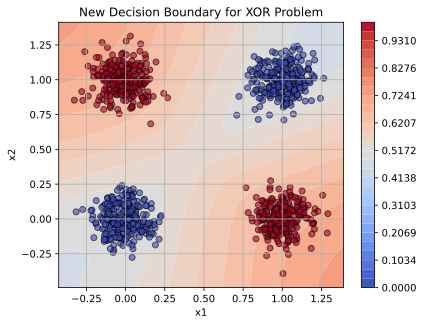

In [26]:
sum1 = area_of_class1(model)


def objective(trial):
    print("sum1 is ", sum1)
    x = trial.suggest_float('x', 0, 100)

    with torch.no_grad():
        model.layer_4.weight = torch.nn.parameter.Parameter(torch.from_numpy(final_layer_weight_modifier(w_real_default, x, nni, f)))

    sum2 = area_of_class1(model)
    print("sum2 is ", sum2)

    with torch.no_grad():
        model.layer_4.weight = w_default 

    return abs(sum2 - (sum1 * 0.8))

study = optuna.create_study(pruner=optuna.pruners.SuccessiveHalvingPruner())
study.optimize(objective, n_trials=500)

with torch.no_grad():
    model.layer_4.weight = torch.nn.parameter.Parameter(torch.from_numpy(final_layer_weight_modifier(w_real_default, 1.258891956182007, nni, f)))

print(area_of_class1(model))
plot_decision_boundary(model, data_numpy, label_numpy, "New Decision Boundary for XOR Problem")
plt.show()
